<a href="https://colab.research.google.com/github/MohiteYash/baby/blob/main/Baby_Fusion_T_sne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio
!pip install librosa
!pip install matplotlib
!pip install scikit-learn
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


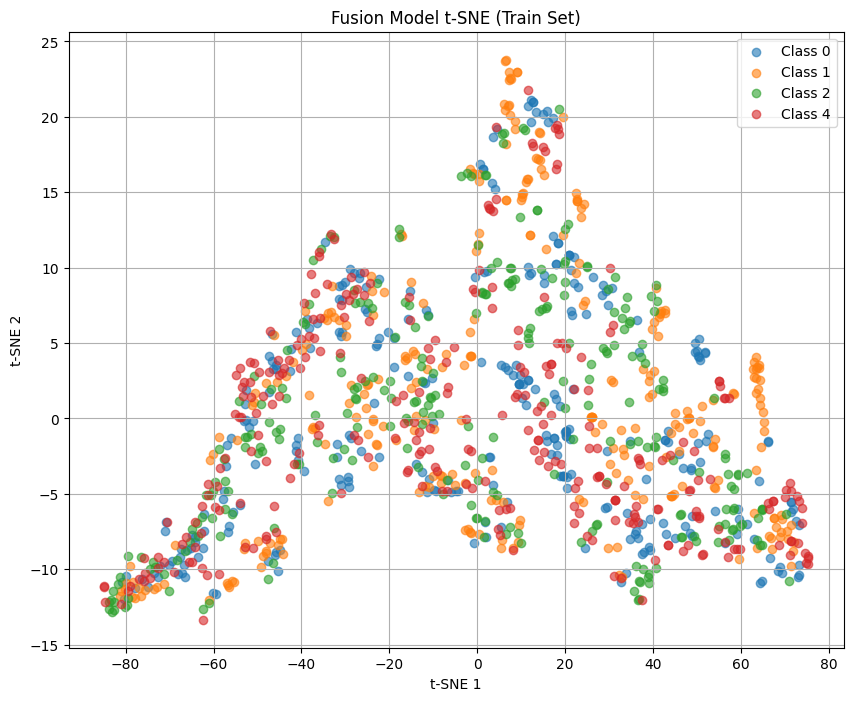

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from transformers import ViTModel, ViTFeatureExtractor
from torch.cuda.amp import autocast, GradScaler

# 1. Dataset
class BabyCryDataset(Dataset):
    def __init__(self, file_paths, labels, sr=22050, max_len=100):
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.max_len = max_len
        self.vit_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        y, sr = librosa.load(file_path, sr=self.sr)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = torch.tensor(mel_spec).unsqueeze(0)
        mel_spec_resized = torch.nn.functional.interpolate(mel_spec.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)

        vit_input = torch.cat([mel_spec_resized] * 3, dim=0)
        resnet_input = torch.cat([mel_spec_resized] * 3, dim=0)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc = np.pad(mfcc, ((0, 0), (0, max(0, self.max_len - mfcc.shape[1]))), mode='constant')[:, :self.max_len]
        mfcc = torch.tensor(mfcc).T

        return vit_input, resnet_input, mfcc, torch.tensor(label, dtype=torch.long)

# 2. Load Data
data_dir = "/content/drive/MyDrive/augmented_baby_cry"
file_paths, labels = [], []

for class_idx, class_name in enumerate(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path) or not os.listdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if fname.endswith(".wav"):
            file_paths.append(os.path.join(class_path, fname))
            labels.append(class_idx)

train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

train_dataset = BabyCryDataset(train_paths, train_labels)
test_dataset = BabyCryDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. Fusion Model
class FusionModel(nn.Module):
    def __init__(self, num_classes=5):
        super(FusionModel, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()

        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit_fc = nn.Linear(768, 512)

        self.lstm = nn.LSTM(input_size=20, hidden_size=128, num_layers=2, batch_first=True)
        self.lstm_fc = nn.Linear(128, 256)

        self.fc1 = nn.Linear(512 + 2048 + 256, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, vit_input, resnet_input, mfcc):
        resnet_features = self.resnet(resnet_input)

        vit_outputs = self.vit(vit_input)
        vit_features = vit_outputs.last_hidden_state[:, 0, :]
        vit_features = self.vit_fc(vit_features)

        lstm_out, _ = self.lstm(mfcc)
        lstm_features = self.lstm_fc(lstm_out[:, -1, :])

        fusion = torch.cat((resnet_features, vit_features, lstm_features), dim=1)
        x = self.fc1(fusion)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# 4. Modified model to extract embeddings
class FusionModelWithEmbeddings(FusionModel):
    def get_embeddings(self, vit_input, resnet_input, mfcc):
        resnet_features = self.resnet(resnet_input)
        vit_features = self.vit(vit_input).last_hidden_state[:, 0, :]
        vit_features = self.vit_fc(vit_features)
        lstm_out, _ = self.lstm(mfcc)
        lstm_features = self.lstm_fc(lstm_out[:, -1, :])
        embeddings = torch.cat((resnet_features, vit_features, lstm_features), dim=1)
        return embeddings

# 5. Embedding extraction function
def extract_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for vit_input, resnet_input, mfcc, labels in dataloader:
            vit_input, resnet_input, mfcc, labels = vit_input.to(device), resnet_input.to(device), mfcc.to(device), labels.to(device)
            embeddings = model.get_embeddings(vit_input, resnet_input, mfcc)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.vstack(all_embeddings), np.hstack(all_labels)

# 6. t-SNE plotting function
def plot_tsne(embeddings, labels, title='t-SNE'):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for c in np.unique(labels):
        idxs = labels == c
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=f'Class {c}', alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()

# 7. Load and Run t-SNE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model weights here if needed
fusion_model = FusionModelWithEmbeddings(num_classes=5).to(device)
# fusion_model.load_state_dict(torch.load("your_model_path.pth"))

# Extract embeddings
train_embeddings, train_labels = extract_embeddings(fusion_model, train_loader, device)

# Plot
plot_tsne(train_embeddings, train_labels, title="Fusion Model t-SNE (Train Set)")


In [ ]:
def get_pipeline1_embeddings(model, data_loader, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for vit_input, resnet_input, _, label in data_loader:
            vit_input, resnet_input = vit_input.to(device), resnet_input.to(device)
            label = label.to(device)

            # Extract ResNet & ViT features
            resnet_feat = model.resnet(resnet_input)
            vit_feat = model.vit(vit_input).last_hidden_state[:, 0, :]
            vit_feat = model.vit_fc(vit_feat)

            combined_feat = torch.cat((resnet_feat, vit_feat), dim=1)  # Shape: [batch, 2048 + 512]
            embeddings.append(combined_feat.cpu())
            labels.append(label.cpu())

    return torch.cat(embeddings).numpy(), torch.cat(labels).numpy()


In [ ]:
def get_pipeline2_embeddings(model, data_loader, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for _, _, mfcc, label in data_loader:
            mfcc = mfcc.to(device)
            label = label.to(device)

            lstm_out, _ = model.lstm(mfcc)
            lstm_feat = model.lstm_fc(lstm_out[:, -1, :])

            embeddings.append(lstm_feat.cpu())
            labels.append(label.cpu())

    return torch.cat(embeddings).numpy(), torch.cat(labels).numpy()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels, title="t-SNE Plot"):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    for class_idx in np.unique(labels):
        idxs = labels == class_idx
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=f"Class {class_idx}", alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


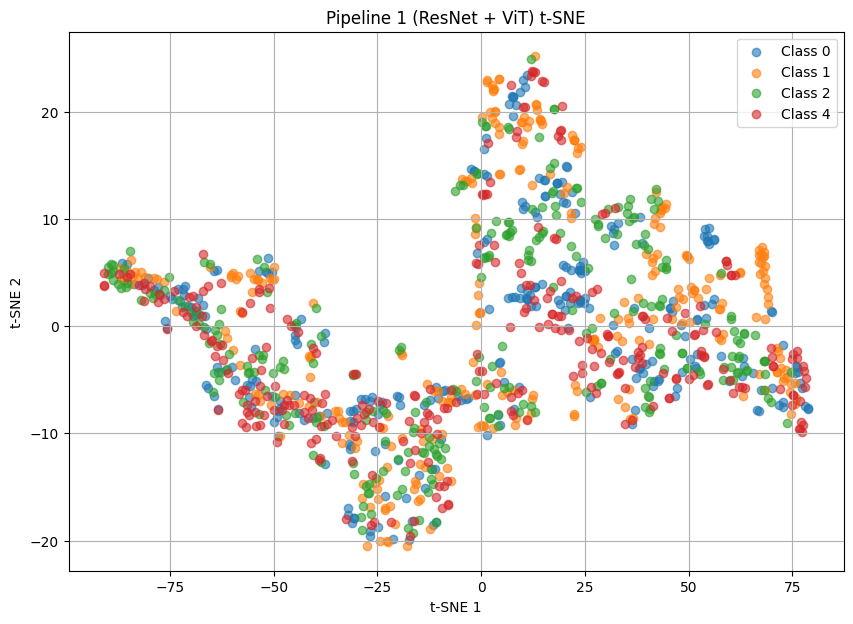

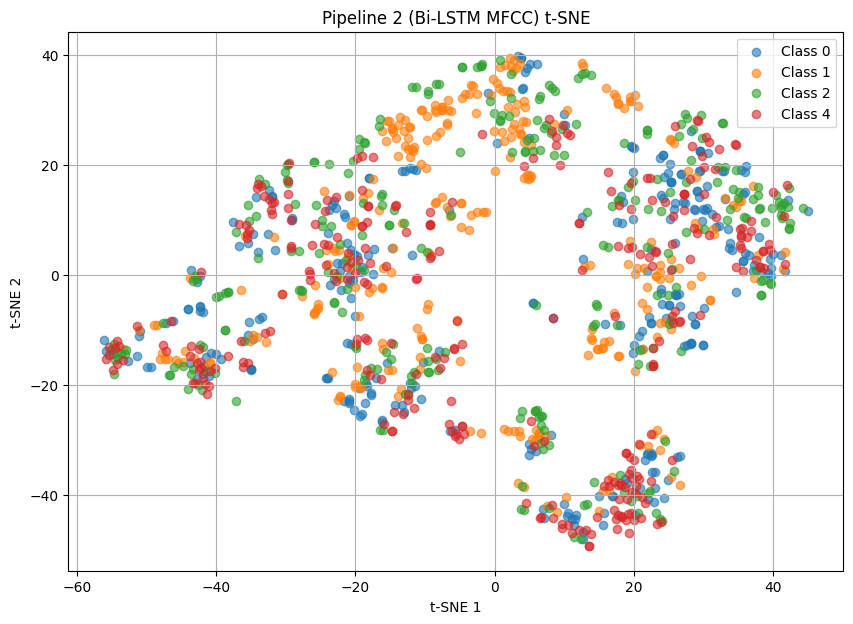

In [ ]:
# Redefine and load the model (assuming you already trained and saved it)

# 1. Redefine the FusionModel class (if not already in your current notebook)
# Paste your class FusionModel definition here

# 2. Initialize and load the model
model = FusionModel(num_classes=5).to(device)

# If you saved your model earlier like:
# torch.save(model.state_dict(), "fusion_model.pth")

# Then load it like this:
# model.load_state_dict(torch.load("fusion_model.pth"))

# 3. Then run the t-SNE embedding extraction
p1_embeddings, p1_labels = get_pipeline1_embeddings(model, train_loader, device)
p2_embeddings, p2_labels = get_pipeline2_embeddings(model, train_loader, device)

# 4. Plot
plot_tsne(p1_embeddings, p1_labels, title="Pipeline 1 (ResNet + ViT) t-SNE")
plot_tsne(p2_embeddings, p2_labels, title="Pipeline 2 (Bi-LSTM MFCC) t-SNE")


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import ViTModel, ViTFeatureExtractor
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training

# 1. Define Dataset Class
class BabyCryDataset(Dataset):
    def __init__(self, file_paths, labels, sr=22050, max_len=100):
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.max_len = max_len
        self.vit_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load audio
        y, sr = librosa.load(file_path, sr=self.sr)

        # Compute Mel Spectrogram (ResNet & ViT)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = torch.tensor(mel_spec).unsqueeze(0)  # (1, 128, Time)
        mel_spec_resized = torch.nn.functional.interpolate(mel_spec.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)

        # Convert 1-channel spectrogram to 3-channel for ResNet & ViT
        vit_input = torch.cat([mel_spec_resized] * 3, dim=0)  # (3, 224, 224)
        resnet_input = torch.cat([mel_spec_resized] * 3, dim=0)  # (3, 224, 224)

        # Compute MFCCs (Bi-LSTM)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc = np.pad(mfcc, ((0, 0), (0, max(0, self.max_len - mfcc.shape[1]))), mode='constant')[:, :self.max_len]
        mfcc = torch.tensor(mfcc).T  # (max_len, 20)

        return vit_input, resnet_input, mfcc, torch.tensor(label, dtype=torch.long)

#2. Load Dataset
data_dir = "/content/drive/MyDrive/augmented_baby_cry"
file_paths, labels = [], []

for class_idx, class_name in enumerate(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path) or not os.listdir(class_path):  # Skip empty folders
        continue
    for fname in os.listdir(class_path):
        if fname.endswith(".wav"):
            file_paths.append(os.path.join(class_path, fname))
            labels.append(class_idx)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create DataLoader
train_dataset = BabyCryDataset(train_paths, train_labels)
test_dataset = BabyCryDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 📌 3. Define Fusion Model
class FusionModel(nn.Module):
    def __init__(self, num_classes=5):
        super(FusionModel, self).__init__()

        # --- ResNet Branch ---
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Identity()
        self.resnet_proj = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- ViT Branch ---
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit_proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Bi-LSTM Branch ---
        self.lstm = nn.LSTM(input_size=20, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.lstm_proj = nn.Sequential(
            nn.Linear(128 * 2, 512),  # Bidirectional = 2x hidden size
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Learnable Weights for Fusion ---
        self.attn_weights = nn.Parameter(torch.ones(3))  # [resnet, vit, lstm]

        # --- Final Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, vit_input, resnet_input, mfcc):
        # --- ResNet ---
        resnet_feat = self.resnet(resnet_input)
        resnet_feat = self.resnet_proj(resnet_feat)

        # --- ViT ---
        vit_outputs = self.vit(vit_input).last_hidden_state[:, 0, :]  # CLS token
        vit_feat = self.vit_proj(vit_outputs)

        # --- LSTM ---
        lstm_out, _ = self.lstm(mfcc)
        lstm_feat = lstm_out[:, -1, :]
        lstm_feat = self.lstm_proj(lstm_feat)

        # --- Weighted Fusion ---
        weights = torch.softmax(self.attn_weights, dim=0)  # Normalize
        fusion = weights[0] * resnet_feat + weights[1] * vit_feat + weights[2] * lstm_feat

        # --- Final Classification ---
        out = self.classifier(fusion)
        return out


# 📌 4. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModel(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  # Mixed precision scaler

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for vit_input, resnet_input, mfcc, labels in train_loader:
        vit_input, resnet_input, mfcc, labels = vit_input.to(device), resnet_input.to(device), mfcc.to(device), labels.to(device)
        labels = labels.squeeze().long()

        optimizer.zero_grad()

        with autocast():
            outputs = model(vit_input, resnet_input, mfcc)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-1-369109ec92b4>:145: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision scaler
<ipython-input-1-369109ec92b4>:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Loss: 1.1162
Epoch 2/20, Loss: 0.9807
Epoch 3/20, Loss: 0.8601
Epoch 4/20, Loss: 0.7075
Epoch 5/20, Loss: 0.7231
Epoch 6/20, Loss: 0.5839
Epoch 7/20, Loss: 0.4587
Epoch 8/20, Loss: 0.4481
Epoch 9/20, Loss: 0.4887
Epoch 10/20, Loss: 0.3671
Epoch 11/20, Loss: 0.3365
Epoch 12/20, Loss: 0.2975
Epoch 13/20, Loss: 0.3593
Epoch 14/20, Loss: 0.2926
Epoch 15/20, Loss: 0.2722
Epoch 16/20, Loss: 0.2946
Epoch 17/20, Loss: 0.2665
Epoch 18/20, Loss: 0.3032
Epoch 19/20, Loss: 0.2392
Epoch 20/20, Loss: 0.2260


In [2]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def extract_embeddings(model, dataloader):
    model.eval()
    resnet_embeds, vit_embeds, lstm_embeds, labels_all = [], [], [], []

    with torch.no_grad():
        for vit_input, resnet_input, mfcc, labels in dataloader:
            vit_input, resnet_input, mfcc = vit_input.to(device), resnet_input.to(device), mfcc.to(device)

            # Feature extraction
            resnet_feat = model.resnet_proj(model.resnet(resnet_input))
            vit_feat = model.vit_proj(model.vit(vit_input).last_hidden_state[:, 0, :])
            lstm_out, _ = model.lstm(mfcc)
            lstm_feat = model.lstm_proj(lstm_out[:, -1, :])

            resnet_embeds.append(resnet_feat.cpu())
            vit_embeds.append(vit_feat.cpu())
            lstm_embeds.append(lstm_feat.cpu())
            labels_all.append(labels)

    return (
        torch.cat(resnet_embeds),
        torch.cat(vit_embeds),
        torch.cat(lstm_embeds),
        torch.cat(labels_all)
    )

def plot_umap(embeddings, labels, title):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
    embeddings_scaled = StandardScaler().fit_transform(embeddings)
    reduced = reducer.fit_transform(embeddings_scaled)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


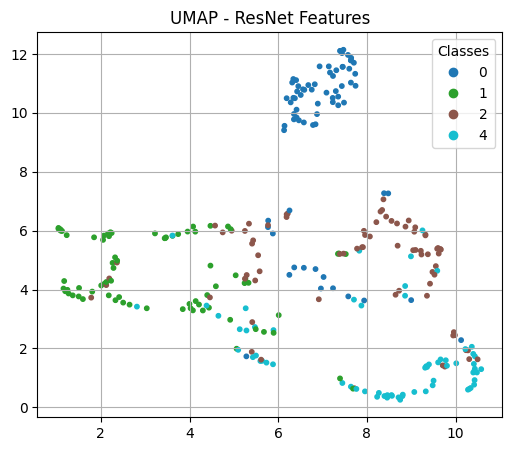

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


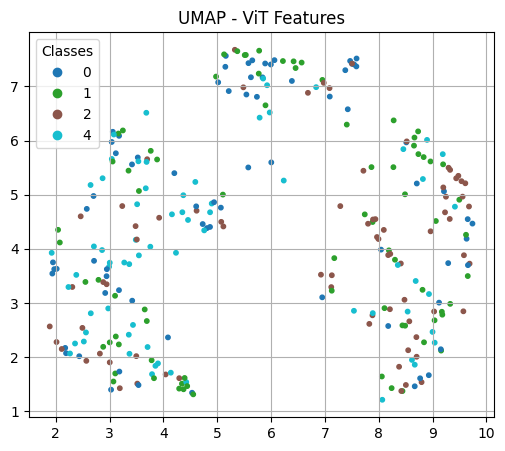

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


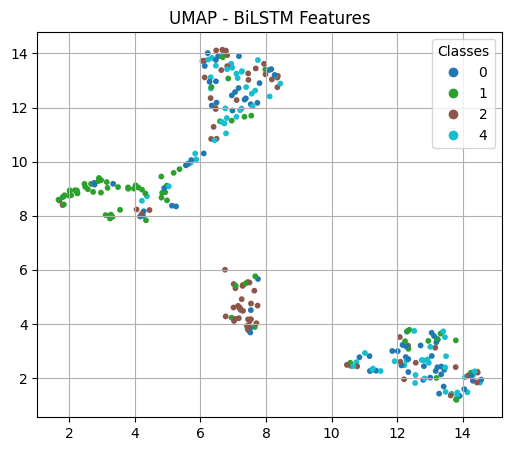

In [3]:
resnet_embed, vit_embed, lstm_embed, embed_labels = extract_embeddings(model, test_loader)

plot_umap(resnet_embed.numpy(), embed_labels.numpy(), "UMAP - ResNet Features")
plot_umap(vit_embed.numpy(), embed_labels.numpy(), "UMAP - ViT Features")
plot_umap(lstm_embed.numpy(), embed_labels.numpy(), "UMAP - BiLSTM Features")
